Stochastic Gradient Descent
======

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 50
learning_rate = 1
batch_size = 50
use_gpu = True

Point Dataset
-------------------

Create a dataset of 2D points

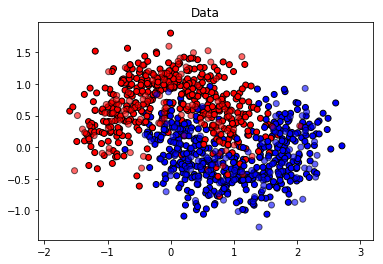

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.ion()
from matplotlib.colors import ListedColormap

# create points
points, labels = make_moons(n_samples = 1000, noise=0.3, random_state=0)

# split into training- and test sets
train_points, test_points, train_labels, test_labels = \
    train_test_split(points, labels, test_size=.2, random_state=1)

# plot points
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig = plt.figure()
plt.scatter(train_points[:, 0], train_points[:, 1], c=train_labels, cmap=cm_bright, edgecolors='k')
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_labels, cmap=cm_bright, alpha=0.6, edgecolors='k')
plt.title('Data')
plt.axis('equal')

train_points = torch.FloatTensor(train_points)
train_labels = torch.FloatTensor(train_labels).view(-1, 1)
test_points = torch.FloatTensor(test_points)
test_labels = torch.FloatTensor(test_labels).view(-1, 1)

train_dataset = list(zip(train_points, train_labels))
test_dataset = list(zip(test_points, test_labels))
# train_dataset = [(torch.FloatTensor(p), torch.FloatTensor([int(l)])) for p, l in zip(train_points, train_labels)]
# test_dataset = [(torch.FloatTensor(p), torch.FloatTensor([int(l)])) for p, l in zip(test_points, test_labels)]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Linear Classifier Definition
-----------------------


In [4]:
linear_gd = nn.Linear(2, 1)
linear_sgd = nn.Linear(2, 1)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
linear_gd = linear_gd.to(device)
linear_sgd = linear_sgd.to(device)

num_params = sum(p.numel() for p in linear_gd.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 3


Optimize (Train) Classifier with GD and SGD
--------
This training implements logisitic regression to train the linear classifier.

In [8]:
def training_step(classifier, points, labels):
    
    # logistic regression to optimize the linear classifier
    class_prob = torch.sigmoid(classifier(points))

    # binary cross-entropy between the predicted class probabilities
    # and the ground truth class probabilities (which are 1 for a single class
    # and 0 for all other classes)
    loss = F.binary_cross_entropy(class_prob, labels)

    # backpropagation
    # this gives us the gradients of the loss w.r.t. the parameters
    # (gradients have to be set to zero first, since pytorch always adds
    # the computed gradients to the current gradients instead of replacing them)
    with torch.no_grad():
        if classifier.weight.grad is not None:
            classifier.weight.grad.zero_()
            classifier.bias.grad.zero_()

    loss.backward()

    # gradient descent step (using the gradients from backpropagation)
    with torch.no_grad():
        classifier.weight.add_(-learning_rate * classifier.weight.grad)
        classifier.bias.add_(-learning_rate * classifier.bias.grad)
    
    return loss

def train_classifier_gd(classifier):

    train_loss = []
    train_weights = []

    for epoch in range(num_epochs):

        points = train_points.to(device)
        labels = train_labels.to(device)

        # gradient descent uses the entire dataset in each step
        loss = training_step(classifier, points, labels)
        
        # store loss and weights for visualization
        train_loss.append(loss.item())
        train_weights.append([
            classifier.weight[0, 0].item(),
            classifier.weight[0, 1].item(),
            classifier.bias[0].item()])

        print('Epoch [%d / %d] loss: %f' % (epoch+1, num_epochs, train_loss[-1]))
    
    return train_loss, train_weights

def train_classifier_sgd(classifier):

    train_loss = []
    train_loss_avg = []
    train_weights = []

    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0

        for point_batch, label_batch in train_dataloader:

            point_batch = point_batch.to(device)
            label_batch = label_batch.to(device)
                
            # stochastic gradient descent uses one data point
            # or a minibatch of data points in each step
            loss = training_step(classifier, point_batch, label_batch)
            
            # store loss and weights for visualization
            train_loss.append(loss.item())
            train_loss_avg[-1] += loss.item()
            num_batches += 1
            train_weights.append([
                classifier.weight[0, 0].item(),
                classifier.weight[0, 1].item(),
                classifier.bias[0].item()])

        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    
    return train_loss, train_loss_avg, train_weights
        
print('Training linear classifier with GD ...')
train_loss_gd, train_weights_gd = train_classifier_gd(linear_gd)
print('Training linear classifier with SGD ...')
train_loss_sgd, train_loss_sgd_avg, train_weights_sgd = train_classifier_sgd(linear_sgd)


Training linear classifier with GD ...
Epoch [1 / 50] loss: 0.871198
Epoch [2 / 50] loss: 0.668025
Epoch [3 / 50] loss: 0.563857
Epoch [4 / 50] loss: 0.510294
Epoch [5 / 50] loss: 0.478427
Epoch [6 / 50] loss: 0.456804
Epoch [7 / 50] loss: 0.440820
Epoch [8 / 50] loss: 0.428353
Epoch [9 / 50] loss: 0.418280
Epoch [10 / 50] loss: 0.409936
Epoch [11 / 50] loss: 0.402894
Epoch [12 / 50] loss: 0.396864
Epoch [13 / 50] loss: 0.391638
Epoch [14 / 50] loss: 0.387062
Epoch [15 / 50] loss: 0.383021
Epoch [16 / 50] loss: 0.379426
Epoch [17 / 50] loss: 0.376205
Epoch [18 / 50] loss: 0.373303
Epoch [19 / 50] loss: 0.370674
Epoch [20 / 50] loss: 0.368282
Epoch [21 / 50] loss: 0.366097
Epoch [22 / 50] loss: 0.364091
Epoch [23 / 50] loss: 0.362246
Epoch [24 / 50] loss: 0.360541
Epoch [25 / 50] loss: 0.358963
Epoch [26 / 50] loss: 0.357497
Epoch [27 / 50] loss: 0.356133
Epoch [28 / 50] loss: 0.354861
Epoch [29 / 50] loss: 0.353672
Epoch [30 / 50] loss: 0.352559
Epoch [31 / 50] loss: 0.351515
Epoch [32

Show Trained Linear Classifiers
--------------------

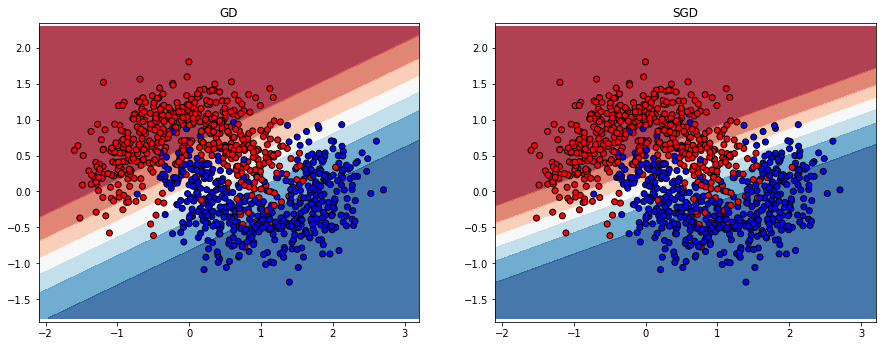

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

with torch.no_grad():

    # create points on a regular 2D grid
    x_min, x_max = points[:, 0].min() - .5, points[:, 0].max() + .5
    y_min, y_max = points[:, 1].min() - .5, points[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    
    # evaluate gd-trained classifier at all grid points
    grid_class_prob_gd = torch.sigmoid(linear_gd(grid_points))
    grid_class_prob_gd = grid_class_prob_gd.cpu().numpy()
    grid_class_prob_gd = grid_class_prob_gd.reshape(xx.shape)

    # evaluate sgd-trained classifier at all grid points
    grid_class_prob_sgd = torch.sigmoid(linear_sgd(grid_points))
    grid_class_prob_sgd = grid_class_prob_sgd.cpu().numpy()
    grid_class_prob_sgd = grid_class_prob_sgd.reshape(xx.shape)

    # plot class probabilities on the grid
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure(figsize=(15, 5.5))

    ax = plt.subplot(1, 2, 1)
    ax.contourf(xx, yy, grid_class_prob_gd, cmap=cm, alpha=.8)
    ax.scatter(points[:, 0], points[:, 1], c=labels, cmap=cm_bright, edgecolors='k')
    ax.set_title('GD')
    ax.axis('equal')

    ax = plt.subplot(1, 2, 2)
    ax.contourf(xx, yy, grid_class_prob_sgd, cmap=cm, alpha=.8)
    ax.scatter(points[:, 0], points[:, 1], c=labels, cmap=cm_bright, edgecolors='k')
    ax.set_title('SGD')
    ax.axis('equal')

    print('')


Plot Training Curve
--------------------
This plot shows the loss with an equal numbers of processed data points. Since SGD updates the parameters more frequently (after looking at only a few points, not the entire dataset), it converges faster than full gradient descent.

Note that we could also increase the learning rate for GD to cover as much distance as SGD does in one epoch (that means multiplying the learning rate of GD by the number of minibatches in an epoch), but this results in a learning rate that is too large - taking one huge step with GD can easily overshoot the optimum.

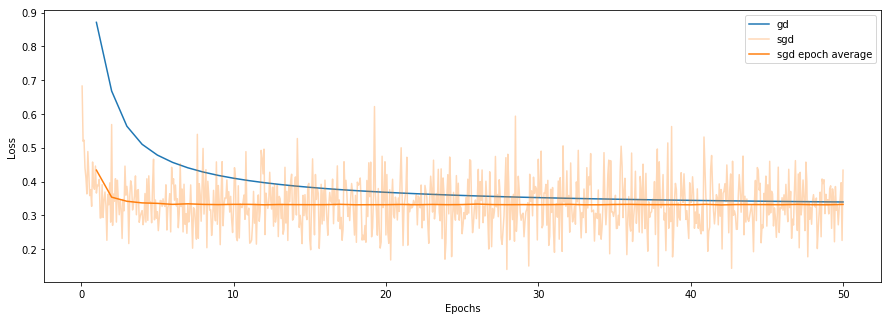

In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

with torch.no_grad():

    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(1, num_epochs, len(train_loss_gd)),
             train_loss_gd, label='gd', color='#1f77b4')
    plt.plot(np.linspace(num_epochs/len(train_loss_sgd), num_epochs, len(train_loss_sgd)),
             train_loss_sgd, label='sgd', alpha=0.3, color='#ff7f0e')
    plt.plot(np.linspace(1, num_epochs, len(train_loss_sgd_avg)),
             train_loss_sgd_avg, label='sgd epoch average', color='#ff7f0e')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Show Path in Parameter Space
--------------------
This plot shows the path of one of the weight parameters and the bias over all iterations.

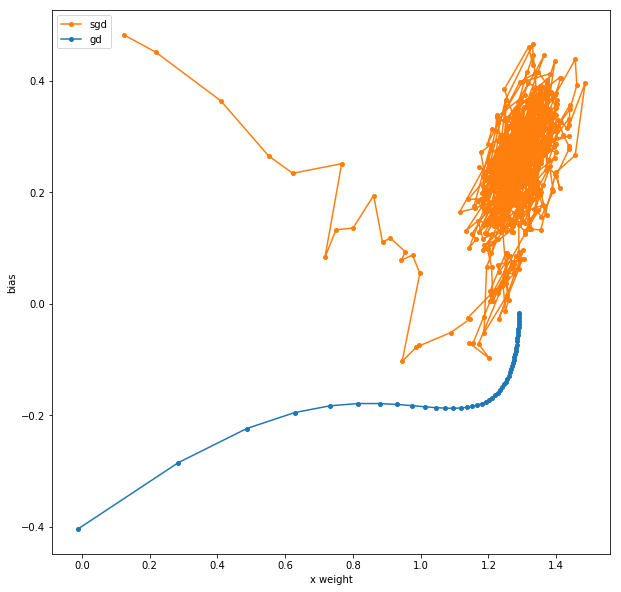

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

with torch.no_grad():

    params_gd = np.array(train_weights_gd)
    params_sgd = np.array(train_weights_sgd)

    fig = plt.figure(figsize=(10, 10))
    plt.plot(params_sgd[:, 0], params_sgd[:, 2], label='sgd', marker='o', markersize=4, color='#ff7f0e')
    plt.plot(params_gd[:, 0], params_gd[:, 2], label='gd', marker='o', markersize=4, color='#1f77b4')
    plt.xlabel('x weight')
    plt.ylabel('bias')
    plt.legend(loc=2)
    plt.show()
